# Multi-Experiment Results Visualization

X축: max_user_seq_len, Y축: metric, 모델별 multi-bar

이 섹션은 여러 데이터셋, 모델, max_user_seq_len 조합의 실험 결과를 통합적으로 시각화합니다.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
from IPython.display import display

# === Configuration ===
RESULTS_ROOT = "./results"  # Root directory containing all results
DATASETS_TO_PLOT = ['redkiwi1', 'redkiwi2', 'redkiwi4', 'redkiwi8', 'redkiwi16', 'redkiwi32', 'redkiwi64']  # Which datasets to visualize  # "alipay", 'amazon', 'tmall', 
METRIC = "AUC"  # Metric to plot: "PRAUC", "AUC", or "logloss"
EVAL_SPLIT = "test"  # "val" or "test"

# === Find all tuner_config.csv files ===
def find_all_result_csvs(results_root):
    """Recursively find all CSV files matching pattern *tuner_config.csv or temp_tuner_*.csv"""
    results = []
    for csv_path in Path(results_root).rglob("*.csv"):
        if "tuner_config" in csv_path.name or "temp_tuner" in csv_path.name:
            results.append(csv_path)
    return results

# === Parse metrics from string ===
pattern = re.compile(
    r"PRAUC:\s*([\d\.]+)\s*-\s*AUC:\s*([\d\.]+)\s*-\s*logloss:\s*([\d\.]+)"
)

def parse_metrics(s):
    m = pattern.search(str(s))
    if m:
        return pd.Series({
            "PRAUC": float(m.group(1)),
            "AUC": float(m.group(2)),
            "logloss": float(m.group(3)),
        })
    return pd.Series({"PRAUC": float("nan"), "AUC": float("nan"), "logloss": float("nan")})

# === Extract dataset, model, max_seq_len from path and filename ===
def parse_experiment_info(row, csv_path):
    """
    Extract (dataset, model, max_seq_len) from:
    - Filename: temp_tuner_{dataset}_{model}_{max_seq_len}.csv
    - Path: results/{dataset}/{max_seq_len}/...
    - Fallback to exp_id parsing
    """
    parts = Path(csv_path).parts
    filename = Path(csv_path).stem  # filename without extension

    # Try parsing from filename: temp_tuner_{dataset}_{model}_{max_seq_len}
    filename_pattern = re.match(r'temp_tuner_(.+?)_(.+?)_(\d+)', filename)
    if filename_pattern:
        dataset = filename_pattern.group(1)
        model = filename_pattern.group(2)
        max_seq_len = int(filename_pattern.group(3))
        return pd.Series({
            "dataset": dataset,
            "model": model,
            "max_seq_len": max_seq_len
        })

    # Fallback: parse from path
    dataset_from_path = parts[-3] if len(parts) >= 3 else None
    max_seq_len_from_path = parts[-2] if len(parts) >= 2 else None

    # Parse model from exp_id
    exp_id_col = [c for c in row.index if '[exp_id]' in str(c)]
    if exp_id_col:
        exp_id = str(row[exp_id_col[0]]).replace('[exp_id]', '').strip()
    else:
        exp_id = str(row.get('exp_id', '')).strip()
    
    model = exp_id.split('_')[0] if exp_id else None

    # Parse max_seq_len from exp_id if available
    maxlen_match = re.search(r'maxlen(\d+)', exp_id)
    max_seq_len = int(maxlen_match.group(1)) if maxlen_match else None

    # Fallback to path-based max_seq_len
    if max_seq_len is None and max_seq_len_from_path:
        max_seq_len = int(max_seq_len_from_path)

    return pd.Series({
        "dataset": dataset_from_path,
        "model": model,
        "max_seq_len": max_seq_len
    })

# === Load and aggregate all results ===
csv_files = find_all_result_csvs(RESULTS_ROOT)
print(f"Found {len(csv_files)} result CSV files")

all_data = []

for csv_path in csv_files:
    df = pd.read_csv(csv_path)

    # Find column names
    exp_col = [c for c in df.columns if '[exp_id]' in c.strip()]
    val_col = [c for c in df.columns if '[val]' in c.strip()]
    test_col = [c for c in df.columns if '[test]' in c.strip()]

    if not exp_col:
        continue

    exp_col = exp_col[0]
    metric_col = test_col[0] if EVAL_SPLIT == "test" and test_col else (val_col[0] if val_col else None)

    if metric_col is None:
        continue

    # Parse experiment info
    df[["dataset", "model", "max_seq_len"]] = df.apply(
        lambda row: parse_experiment_info(row, csv_path), axis=1
    )

    # Parse metrics
    df[["PRAUC", "AUC", "logloss"]] = df[metric_col].apply(parse_metrics)

    # Keep relevant columns
    df_subset = df[["dataset", "model", "max_seq_len", "PRAUC", "AUC", "logloss"]].copy()
    all_data.append(df_subset)

import re

def sort_datasets_redkiwi_first(datasets, prefix="redkiwi"):
    pat = re.compile(rf"^{re.escape(prefix)}(\d+)$")
    redkiwi = []
    others = []
    for d in datasets:
        s = str(d)
        m = pat.match(s)
        if m:
            redkiwi.append((int(m.group(1)), d))
        else:
            others.append(d)

    redkiwi.sort(key=lambda x: x[0])
    # others는 원래 순서 유지하고 싶으면 그대로, 알파벳 정렬 원하면 sorted(others)
    return [d for _, d in redkiwi] + list(others)

import numpy as np
import matplotlib.pyplot as plt

def make_colors(n, cmap_name="tab20"):
    cmap = plt.get_cmap(cmap_name)
    # colormap을 0~1 구간에서 n개 균등 샘플링
    return [cmap(x) for x in np.linspace(0, 1, n)]

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)

# Remove rows with missing values
combined_df = combined_df.dropna(subset=["dataset", "model", "max_seq_len", METRIC])

# Group by (dataset, model, max_seq_len) and get best result
grouped = combined_df.groupby(["dataset", "model", "max_seq_len"])[METRIC]

if METRIC == "logloss":
    best_idx = grouped.idxmin()
else:
    best_idx = grouped.idxmax()

best_results = combined_df.loc[best_idx].reset_index(drop=True)

print(f"Total best results: {len(best_results)}")
display(best_results.head(10))

Found 640 result CSV files
Total best results: 640


,dataset,model,max_seq_len,PRAUC,AUC,logloss
0,alipay,eta,64,0.502298,0.502070,0.727225
1,alipay,eta,128,0.502910,0.502595,0.738680
2,alipay,eta,256,0.502402,0.503223,1.711689
3,alipay,eta,512,0.502066,0.501402,0.981851
4,alipay,eta,1024,0.502066,0.501402,0.981851
5,alipay,eta,2048,0.502066,0.501402,0.981851
6,alipay,eta,4096,0.502066,0.501402,0.981851
7,alipay,eta,8192,0.502066,0.501402,0.981851
8,alipay,mirrn,64,0.503738,0.503201,0.700111
9,alipay,mirrn,128,0.504833,0.503474,0.693145


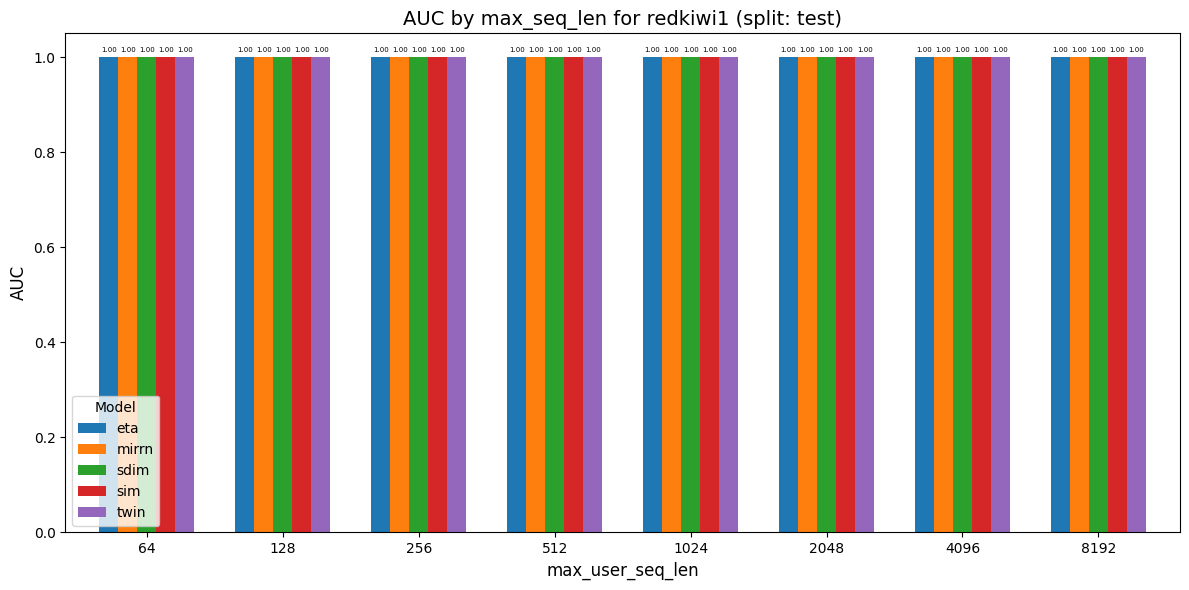


Table for redkiwi1:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.999827,0.999972,0.999965,0.999834,0.999854
128,0.999869,0.999973,0.999924,0.999848,0.999854
256,0.999860,0.999971,0.999971,0.999823,0.999848
512,0.999812,0.999963,0.999979,0.999856,0.999850
1024,0.999817,0.999967,0.999966,0.999845,0.999848
2048,0.999868,0.999967,0.999982,0.999826,0.999850
4096,0.999857,0.999956,0.999954,0.999810,0.999852
8192,0.999862,0.999975,0.999990,0.999813,0.999850


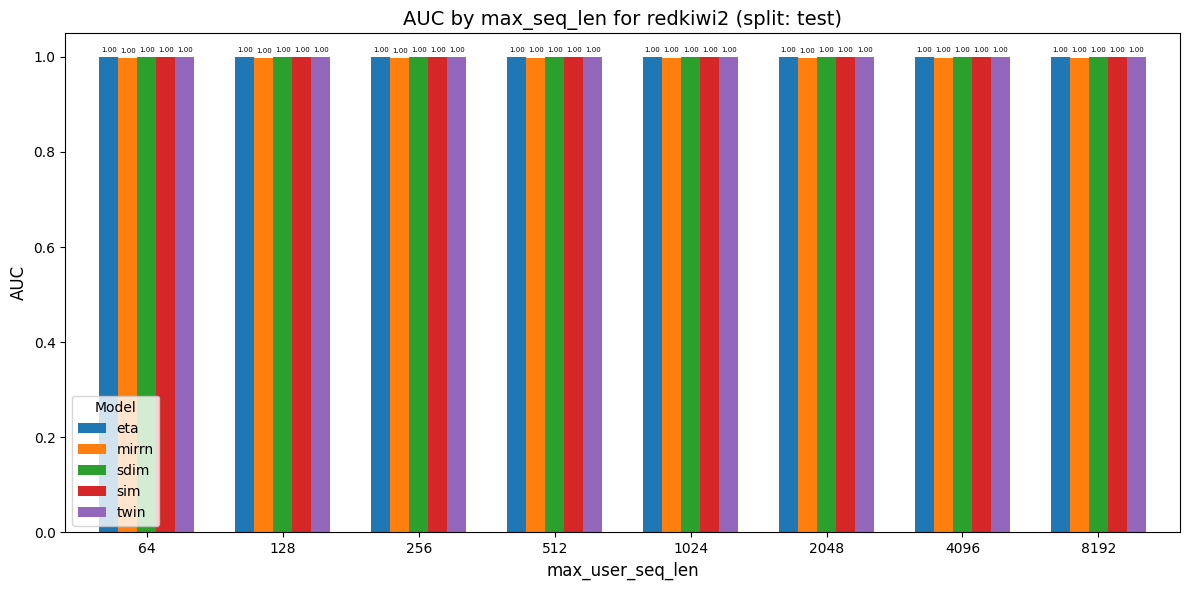


Table for redkiwi2:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.999405,0.997733,0.999462,0.999337,0.999469
128,0.999387,0.998046,0.999276,0.999399,0.999400
256,0.999338,0.998113,0.999394,0.999273,0.999453
512,0.999319,0.998409,0.999408,0.999184,0.999493
1024,0.999442,0.998579,0.999244,0.999313,0.999460
2048,0.999203,0.997564,0.999238,0.999367,0.999364
4096,0.999228,0.998359,0.999409,0.999357,0.999505
8192,0.999210,0.998560,0.999219,0.999311,0.999547


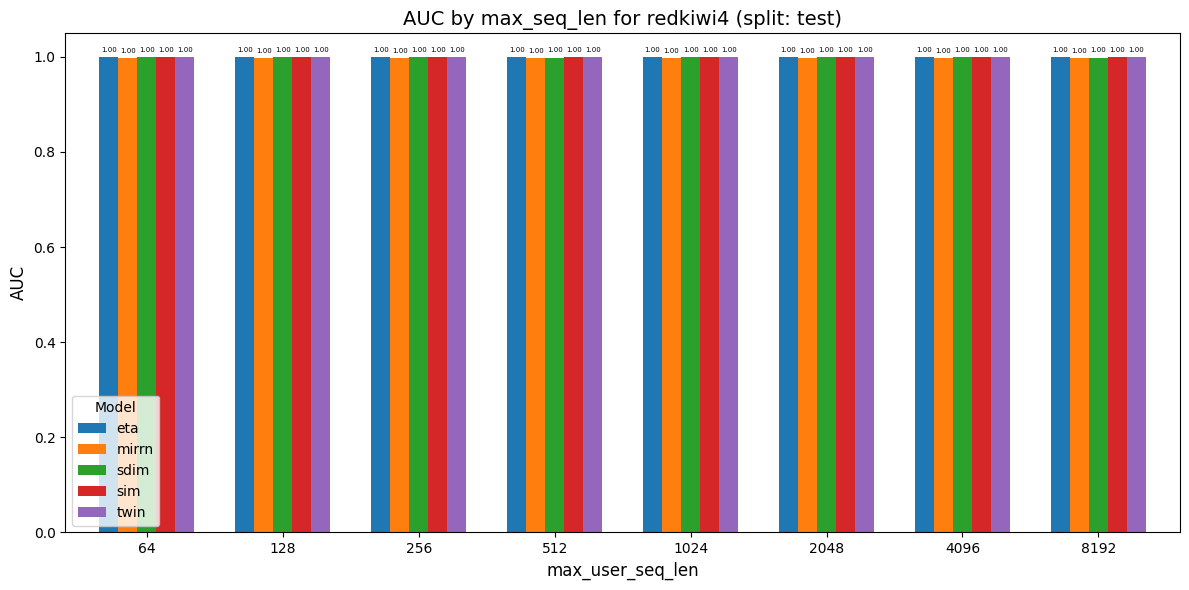


Table for redkiwi4:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.999167,0.996550,0.998987,0.999169,0.999161
128,0.999117,0.997281,0.998805,0.999153,0.999176
256,0.999193,0.996932,0.998596,0.999119,0.999141
512,0.999119,0.996873,0.998351,0.999130,0.999111
1024,0.999167,0.997328,0.998900,0.999115,0.999132
2048,0.999140,0.997036,0.999021,0.999131,0.999147
4096,0.999110,0.996477,0.998479,0.999138,0.999177
8192,0.999108,0.996466,0.998336,0.999138,0.999155


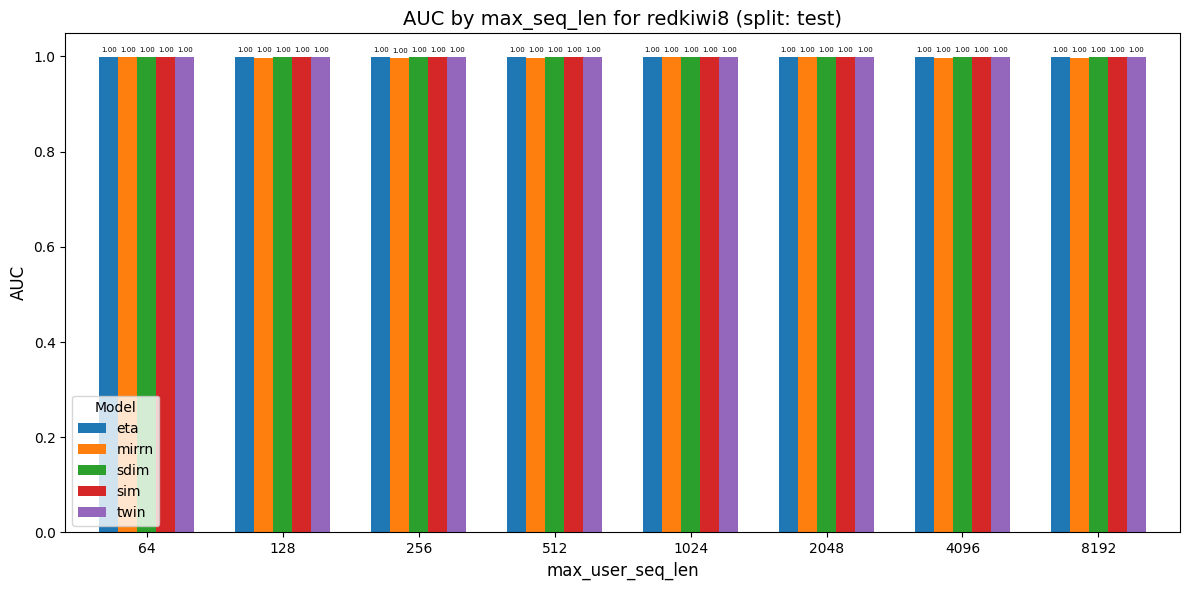


Table for redkiwi8:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.998438,0.997752,0.998199,0.998430,0.998378
128,0.998322,0.997513,0.998066,0.998489,0.998300
256,0.998351,0.996952,0.998348,0.998388,0.998336
512,0.998342,0.997686,0.998111,0.998399,0.998308
1024,0.998485,0.997939,0.998440,0.998549,0.998519
2048,0.998526,0.998094,0.998140,0.998492,0.998510
4096,0.998443,0.997612,0.998321,0.998486,0.998474
8192,0.998384,0.997524,0.998300,0.998519,0.998488


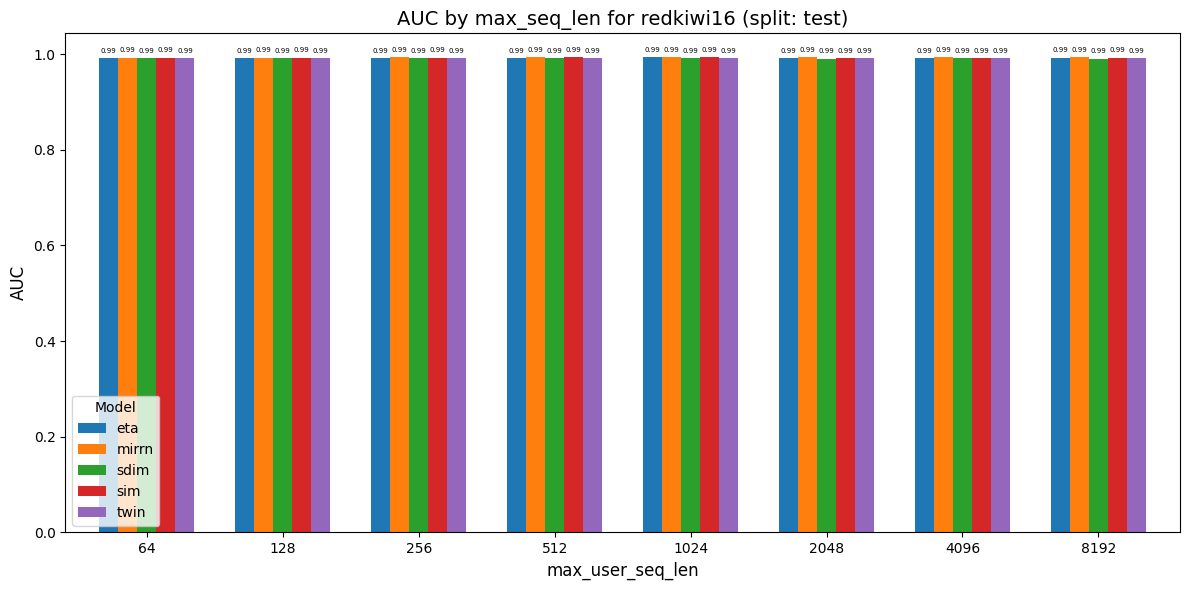


Table for redkiwi16:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.992311,0.992733,0.990999,0.992624,0.992552
128,0.992250,0.992844,0.990966,0.992842,0.992245
256,0.991863,0.993254,0.991849,0.992850,0.992157
512,0.991821,0.993806,0.991118,0.993162,0.992374
1024,0.993063,0.993691,0.991325,0.993275,0.992217
2048,0.991814,0.993306,0.990683,0.992489,0.992453
4096,0.991621,0.993563,0.991703,0.992448,0.992346
8192,0.992970,0.993781,0.990705,0.992681,0.991938


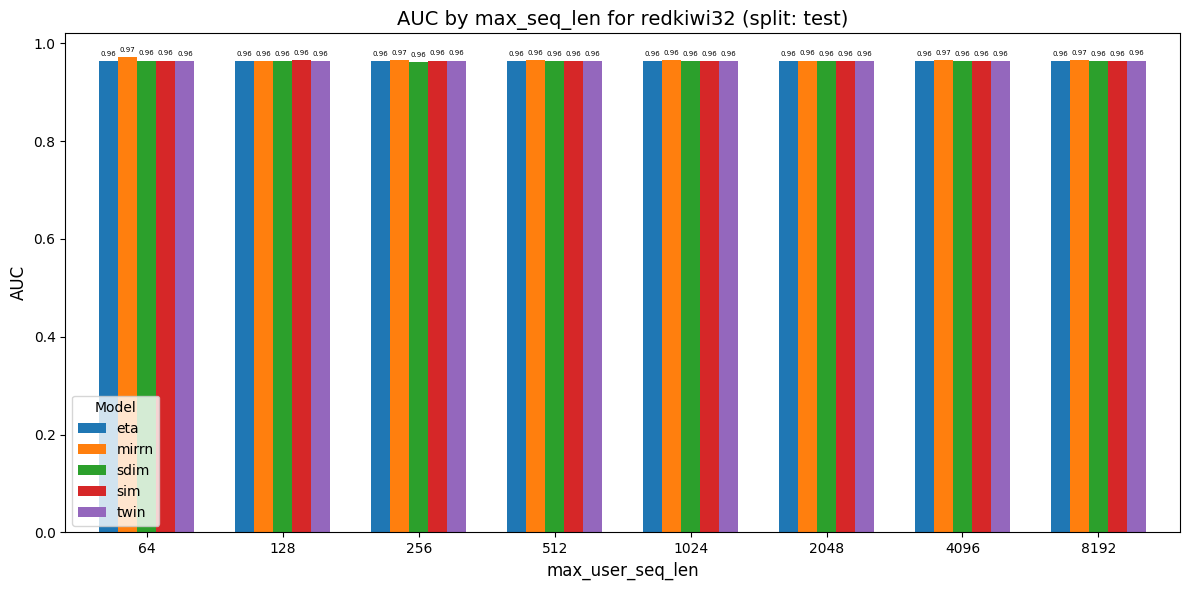


Table for redkiwi32:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.964375,0.971763,0.964656,0.964605,0.964286
128,0.964434,0.964465,0.963920,0.964890,0.964406
256,0.964064,0.965465,0.962318,0.964659,0.964739
512,0.963996,0.964963,0.964440,0.964134,0.964329
1024,0.963960,0.964866,0.964059,0.963791,0.964420
2048,0.964284,0.964794,0.963259,0.964370,0.964403
4096,0.963791,0.965494,0.964006,0.964016,0.964315
8192,0.964391,0.966417,0.964148,0.964000,0.964637


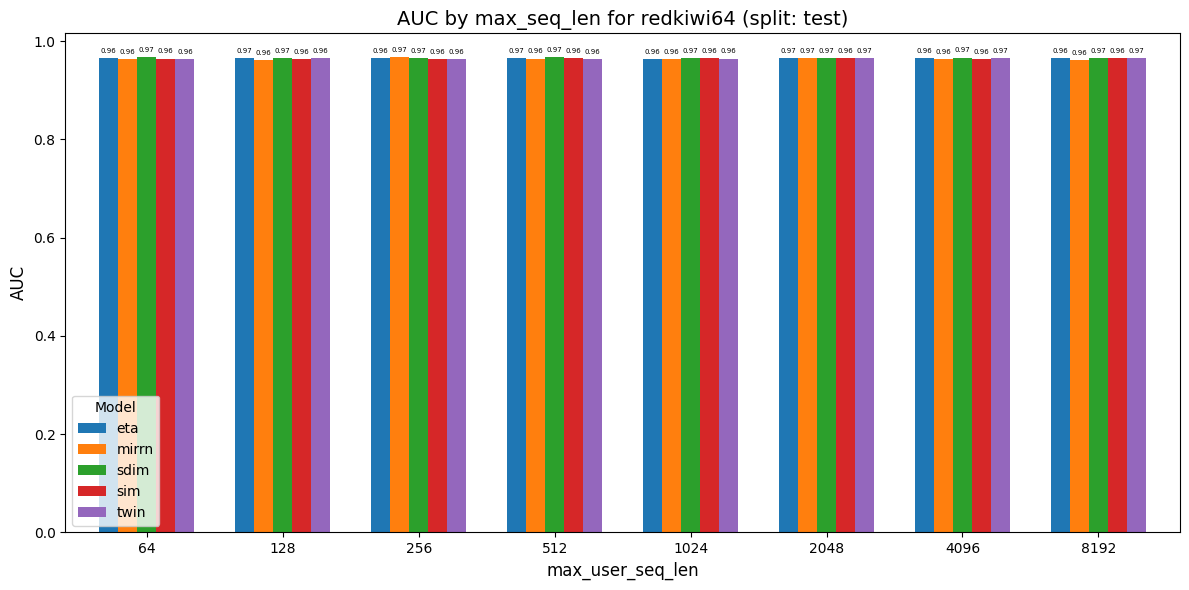


Table for redkiwi64:


model,eta,mirrn,sdim,sim,twin
max_seq_len,,,,,
64,0.964882,0.963237,0.967576,0.964727,0.964076
128,0.965162,0.961426,0.965554,0.964376,0.964866
256,0.964851,0.966968,0.966058,0.963959,0.964118
512,0.965092,0.964602,0.967400,0.964746,0.964246
1024,0.964288,0.962818,0.966366,0.964901,0.964413
2048,0.965038,0.965088,0.965909,0.964796,0.966235
4096,0.964935,0.964133,0.966703,0.964172,0.965114
8192,0.964956,0.962260,0.965885,0.964823,0.965515


In [57]:
# === Plot separate graph per dataset ===
for dataset_name in DATASETS_TO_PLOT:
    # Filter data for this dataset
    dataset_df = best_results[best_results["dataset"] == dataset_name].copy()

    if dataset_df.empty:
        print(f"No data for dataset: {dataset_name}")
        continue

    # Pivot: rows=max_seq_len, columns=model, values=metric
    pivot = dataset_df.pivot(
        index="max_seq_len",
        columns="model",
        values=METRIC
    )

    # Sort by max_seq_len
    pivot = pivot.sort_index()

    # Plot
    ax = pivot.plot(
        kind="bar",
        figsize=(12, 6),
        width=0.7
    )

    ax.set_xlabel("max_user_seq_len", fontsize=12)
    ax.set_ylabel(METRIC, fontsize=12)
    ax.set_title(
        f"{METRIC} by max_seq_len for {dataset_name} (split: {EVAL_SPLIT})",
        fontsize=14
    )

    plt.xticks(rotation=0)
    plt.legend(title="Model", loc="best")

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=5, fmt='%.2f')

    plt.tight_layout()
    plt.show()

    # Also show as table
    print(f"\nTable for {dataset_name}:")
    display(pivot)

# Max_seq_len 외에 다른 기준으로 한 것

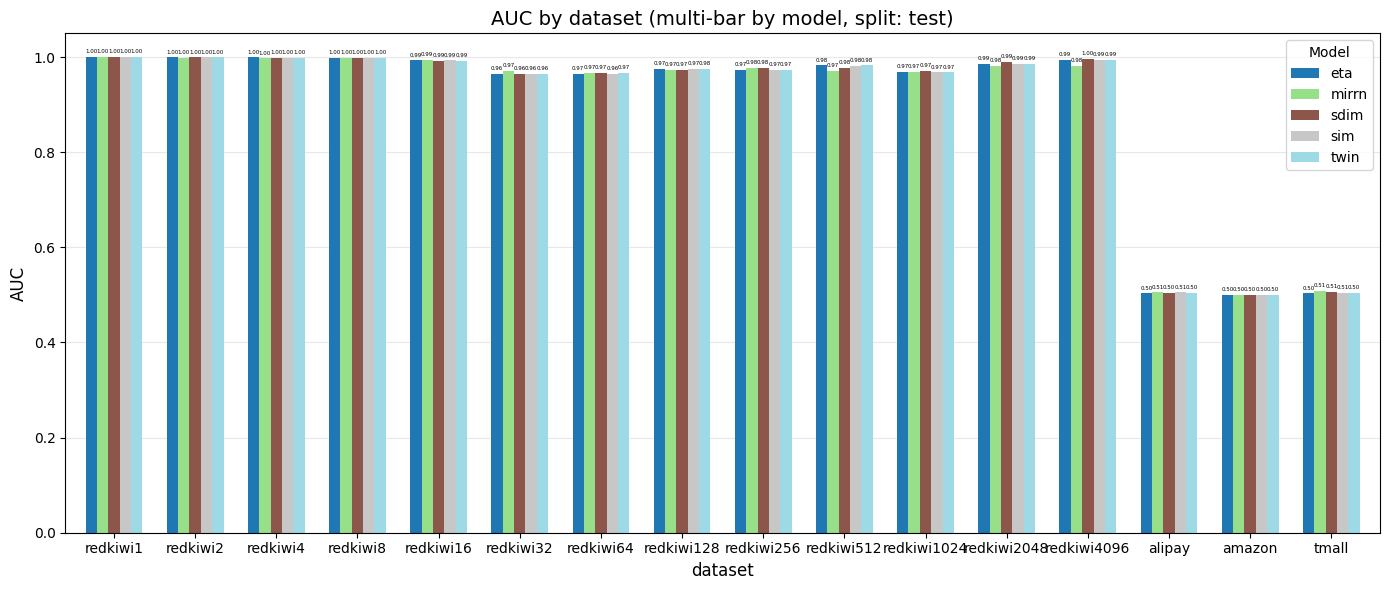


[Table] dataset x model


model,eta,mirrn,sdim,sim,twin
dataset,,,,,
redkiwi1,0.999869,0.999975,0.999990,0.999856,0.999854
redkiwi2,0.999442,0.998579,0.999462,0.999399,0.999547
redkiwi4,0.999193,0.997328,0.999021,0.999169,0.999177
redkiwi8,0.998526,0.998094,0.998440,0.998549,0.998519
redkiwi16,0.993063,0.993806,0.991849,0.993275,0.992552
redkiwi32,0.964434,0.971763,0.964656,0.964890,0.964739
redkiwi64,0.965162,0.966968,0.967576,0.964901,0.966235
redkiwi128,0.974671,0.972869,0.972522,0.974864,0.975043
redkiwi256,0.973412,0.976908,0.977266,0.972694,0.973806


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ===== 추가 시각화 설정 =====
TOP_N_MAXLEN = None     # 예: 5로 두면 max_seq_len 상위 5개만 표시 (None이면 전부)
TOP_N_DATASETS = None   # 예: 10 (None이면 전부)
FIGSIZE = (14, 6)
BAR_WIDTH = 0.8

def _format_ax(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis="y", alpha=0.3)
    ax.set_axisbelow(True)

def _add_bar_labels(ax, fmt="%.4f"):
    for container in ax.containers:
        ax.bar_label(container, padding=2, fontsize=4, fmt=fmt)

def _maybe_topn_index(df_pivot, top_n, metric=METRIC):
    if top_n is None:
        return df_pivot
    # row별 최대(또는 최소) 기준으로 상위 top_n 뽑기
    row_score = df_pivot.max(axis=1) if metric != "logloss" else df_pivot.min(axis=1)
    keep = row_score.sort_values(ascending=(metric == "logloss")).head(top_n).index
    return df_pivot.loc[keep]

def _maybe_topn_columns(df_pivot, top_n, metric=METRIC):
    if top_n is None:
        return df_pivot
    col_score = df_pivot.max(axis=0) if metric != "logloss" else df_pivot.min(axis=0)
    keep = col_score.sort_values(ascending=(metric == "logloss")).head(top_n).index
    return df_pivot[keep]

# ============================================================
# 1) X축=dataset, Y축=metric, 여러 모델 multi-bar
#    - 기준 max_seq_len을 하나 고르거나(예: best overall maxlen),
#      또는 dataset별로 model의 best(max_seq_len 무관)로 뽑을 수 있음.
#    여기서는 "dataset, model" 별로 max_seq_len 상관없이 best를 한 번 더 선택해서 그림.
# ============================================================

# (dataset, model) 단위로 best 선택
grp_dm = combined_df.groupby(["dataset", "model"])[METRIC]
idx_dm = grp_dm.idxmin() if METRIC == "logloss" else grp_dm.idxmax()
best_dm = combined_df.loc[idx_dm].reset_index(drop=True)

# pivot: rows=dataset, cols=model
pivot_dataset_model = best_dm.pivot(index="dataset", columns="model", values=METRIC)

order = sort_datasets_redkiwi_first(pivot_dataset_model.index)
pivot_dataset_model = pivot_dataset_model.reindex(order)


# 표시는 너무 많을 수 있으니 top_n_dataset / top_n_model 옵션 적용
pivot_dataset_model = _maybe_topn_index(pivot_dataset_model, TOP_N_DATASETS, METRIC)
pivot_dataset_model = _maybe_topn_columns(pivot_dataset_model, None, METRIC)  # 모델 top_n 필요하면 None 대신 숫자

# pivot_dataset_model = pivot_dataset_model.sort_index()

colors = make_colors(pivot_dataset_model.shape[1], cmap_name="tab20")  # 모델 개수만큼
ax = pivot_dataset_model.plot(kind="bar", figsize=FIGSIZE, width=0.7, color=colors)
_format_ax(
    ax,
    xlabel="dataset",
    ylabel=METRIC,
    title=f"{METRIC} by dataset (multi-bar by model, split: {EVAL_SPLIT})"
)
plt.xticks(rotation=0)
plt.legend(title="Model", loc="best")
_add_bar_labels(ax, fmt="%.2f")
plt.tight_layout()
plt.show()

print("\n[Table] dataset x model")
display(pivot_dataset_model)

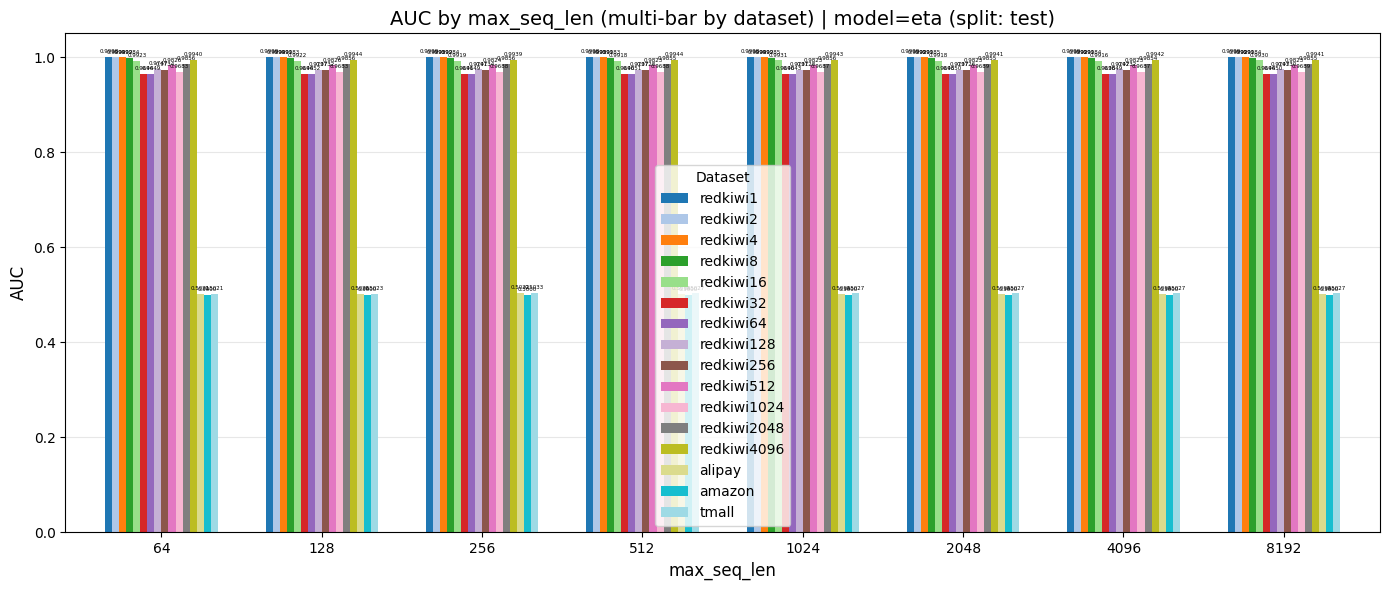


[Table] max_seq_len x dataset (model=eta)


dataset,redkiwi1,redkiwi2,redkiwi4,redkiwi8,redkiwi16,redkiwi32,redkiwi64,redkiwi128,redkiwi256,redkiwi512,redkiwi1024,redkiwi2048,redkiwi4096,alipay,amazon,tmall
max_seq_len,,,,,,,,,,,,,,,,
64,0.999827,0.999405,0.999167,0.998438,0.992311,0.964375,0.964882,0.974671,0.973352,0.982580,0.968306,0.985566,0.994044,0.502070,0.5,0.502095
128,0.999869,0.999387,0.999117,0.998322,0.992250,0.964434,0.965162,0.973685,0.973172,0.982628,0.968341,0.985582,0.994366,0.502595,0.5,0.502280
256,0.999860,0.999338,0.999193,0.998351,0.991863,0.964064,0.964851,0.974055,0.973412,0.982357,0.968831,0.985582,0.993921,0.503223,0.5,0.503309
512,0.999812,0.999319,0.999119,0.998342,0.991821,0.963996,0.965092,0.973723,0.972768,0.982340,0.968785,0.985508,0.994374,0.501402,0.5,0.502700
1024,0.999817,0.999442,0.999167,0.998485,0.993063,0.963960,0.964288,0.973105,0.972842,0.982299,0.968704,0.985550,0.994267,0.501402,0.5,0.502700
2048,0.999868,0.999203,0.999140,0.998526,0.991814,0.964284,0.965038,0.973651,0.972646,0.982322,0.968866,0.985500,0.994094,0.501402,0.5,0.502700
4096,0.999857,0.999228,0.999110,0.998443,0.991621,0.963791,0.964935,0.974156,0.973167,0.982272,0.968688,0.985442,0.994193,0.501402,0.5,0.502700
8192,0.999862,0.999210,0.999108,0.998384,0.992970,0.964391,0.964956,0.974256,0.973012,0.982320,0.968908,0.985467,0.994053,0.501402,0.5,0.502700


In [59]:
# ============================================================
# 2) X축=max_seq_len, Y축=metric, 여러 dataset multi-bar
#    - 특정 모델을 하나 고르고(dataset별 성능 비교), 또는
#      model별로 best를 뽑아서 dataset 비교가 가능.
#    여기서는 "model을 하나 지정"하는 방식 + (dataset,max_seq_len)에서 best 모델도 함께 제공.
# ============================================================

# (A) 특정 모델 기준: X=max_seq_len, bars=dataset
MODEL_TO_PLOT = None  # 예: "DIN" / "SASRec" 등. None이면 자동으로 가장 많이 등장한 모델 사용

if MODEL_TO_PLOT is None:
    MODEL_TO_PLOT = best_results["model"].value_counts().index[0]

model_df = best_results[best_results["model"] == MODEL_TO_PLOT].copy()
pivot_maxlen_dataset = model_df.pivot(index="max_seq_len", columns="dataset", values=METRIC).sort_index()

order = sort_datasets_redkiwi_first(pivot_maxlen_dataset.columns)
pivot_maxlen_dataset = pivot_maxlen_dataset.reindex(columns=order)

pivot_maxlen_dataset = _maybe_topn_index(pivot_maxlen_dataset, TOP_N_MAXLEN, METRIC)
pivot_maxlen_dataset = _maybe_topn_columns(pivot_maxlen_dataset, TOP_N_DATASETS, METRIC)

colors = make_colors(pivot_maxlen_dataset.shape[1], cmap_name="tab20")  # 모델 개수만큼
ax = pivot_maxlen_dataset.plot(kind="bar", figsize=FIGSIZE, width=0.7, color=colors)
_format_ax(
    ax,
    xlabel="max_seq_len",
    ylabel=METRIC,
    title=f"{METRIC} by max_seq_len (multi-bar by dataset) | model={MODEL_TO_PLOT} (split: {EVAL_SPLIT})"
)
plt.xticks(rotation=0)
plt.legend(title="Dataset", loc="best")
_add_bar_labels(ax, fmt="%.4f")
plt.tight_layout()
plt.show()

print(f"\n[Table] max_seq_len x dataset (model={MODEL_TO_PLOT})")
display(pivot_maxlen_dataset)

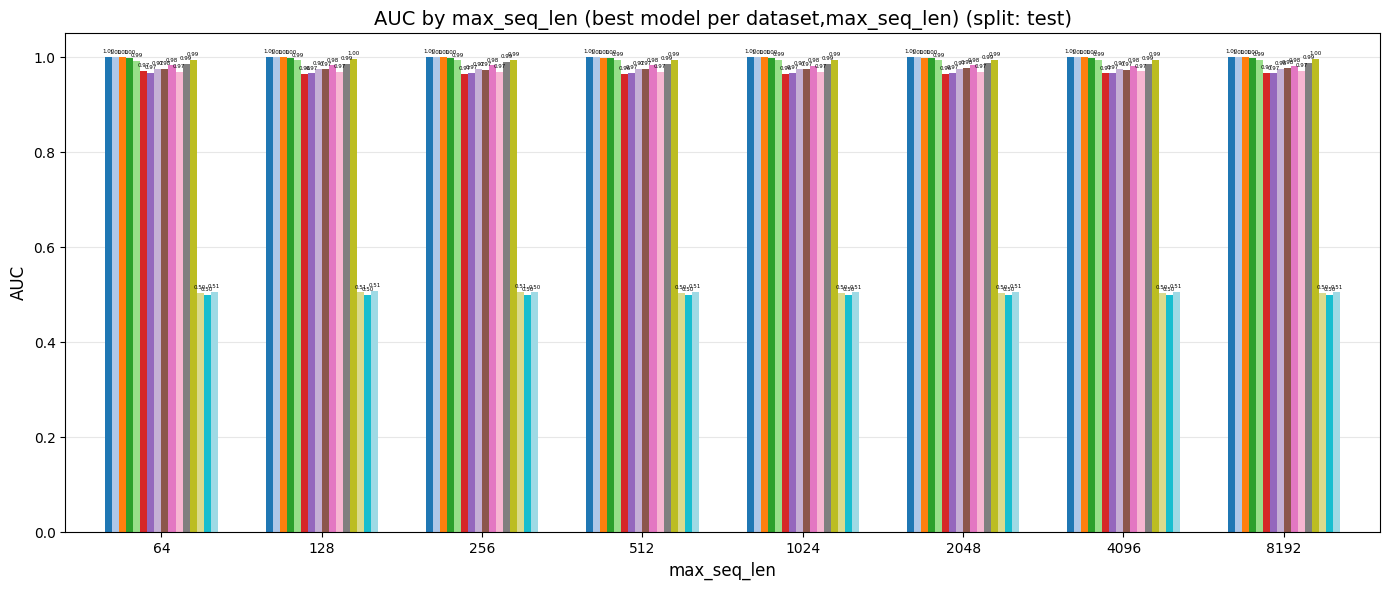

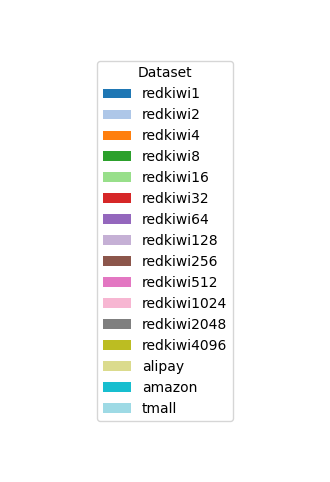


[Table] max_seq_len x dataset (best model per cell)


dataset,redkiwi1,redkiwi2,redkiwi4,redkiwi8,redkiwi16,redkiwi32,redkiwi64,redkiwi128,redkiwi256,redkiwi512,redkiwi1024,redkiwi2048,redkiwi4096,alipay,amazon,tmall
max_seq_len,,,,,,,,,,,,,,,,
64,0.999972,0.999469,0.999169,0.998438,0.992733,0.971763,0.967576,0.974671,0.975426,0.982580,0.968306,0.986332,0.994259,0.504493,0.5,0.506617
128,0.999973,0.999400,0.999176,0.998489,0.992844,0.964890,0.965554,0.974599,0.974042,0.982747,0.968341,0.985994,0.995455,0.505236,0.5,0.508316
256,0.999971,0.999453,0.999193,0.998388,0.993254,0.965465,0.966968,0.974348,0.973412,0.982357,0.968831,0.990295,0.994308,0.505351,0.5,0.504958
512,0.999979,0.999493,0.999130,0.998399,0.993806,0.964963,0.967400,0.974864,0.974917,0.982340,0.968785,0.986480,0.994614,0.503752,0.5,0.505858
1024,0.999967,0.999460,0.999167,0.998549,0.993691,0.964866,0.966366,0.974413,0.974146,0.982299,0.968704,0.986134,0.994671,0.503752,0.5,0.505227
2048,0.999982,0.999367,0.999147,0.998526,0.993306,0.964794,0.966235,0.974745,0.977266,0.982640,0.968866,0.987749,0.994853,0.503752,0.5,0.505858
4096,0.999956,0.999505,0.999177,0.998486,0.993563,0.965494,0.966703,0.974816,0.973806,0.982272,0.969986,0.986151,0.994193,0.503752,0.5,0.505858
8192,0.999990,0.999547,0.999155,0.998519,0.993781,0.966417,0.965885,0.975043,0.976908,0.982320,0.971176,0.988540,0.996107,0.503752,0.5,0.505227



[Table] best model per (max_seq_len, dataset)


dataset,redkiwi1,redkiwi2,redkiwi4,redkiwi8,redkiwi16,redkiwi32,redkiwi64,redkiwi128,redkiwi256,redkiwi512,redkiwi1024,redkiwi2048,redkiwi4096,alipay,amazon,tmall
max_seq_len,,,,,,,,,,,,,,,,
64,mirrn,twin,sim,eta,mirrn,mirrn,sdim,eta,mirrn,eta,eta,sdim,twin,twin,eta,sdim
128,mirrn,twin,twin,sim,mirrn,sim,sdim,sim,mirrn,twin,eta,twin,sdim,sim,eta,mirrn
256,mirrn,twin,eta,sim,mirrn,mirrn,mirrn,twin,eta,eta,eta,sdim,twin,mirrn,eta,mirrn
512,sdim,twin,sim,sim,mirrn,mirrn,sdim,sim,mirrn,eta,eta,twin,sdim,mirrn,eta,mirrn
1024,mirrn,twin,eta,sim,mirrn,mirrn,sdim,twin,sdim,eta,eta,twin,sdim,mirrn,eta,sdim
2048,sdim,sim,twin,eta,mirrn,mirrn,twin,twin,sdim,twin,eta,sdim,sdim,mirrn,eta,mirrn
4096,mirrn,twin,twin,sim,mirrn,mirrn,sdim,twin,twin,eta,sdim,twin,eta,mirrn,eta,mirrn
8192,sdim,twin,twin,sim,mirrn,mirrn,sdim,twin,mirrn,eta,sdim,sdim,sdim,mirrn,eta,sdim


In [60]:
# (B) 참고용 추가: (dataset, max_seq_len)에서 "가장 좋은 모델"이 뭔지도 보고 싶으면 (자동 best model)
grp_dml = combined_df.groupby(["dataset", "max_seq_len"])[METRIC]
idx_dml = grp_dml.idxmin() if METRIC == "logloss" else grp_dml.idxmax()
best_dml = combined_df.loc[idx_dml].reset_index(drop=True)

pivot_bestmodel = best_dml.pivot(index="max_seq_len", columns="dataset", values=METRIC).sort_index()

order = sort_datasets_redkiwi_first(pivot_bestmodel.columns)
pivot_bestmodel = pivot_bestmodel.reindex(columns=order)

pivot_bestmodel = _maybe_topn_index(pivot_bestmodel, TOP_N_MAXLEN, METRIC)
pivot_bestmodel = _maybe_topn_columns(pivot_bestmodel, TOP_N_DATASETS, METRIC)

colors = make_colors(pivot_bestmodel.shape[1], cmap_name="tab20")  # 모델 개수만큼

ax = pivot_bestmodel.plot(
    kind="bar",
    figsize=FIGSIZE,
    width=0.7,
    color=colors,
    legend=False
)

_format_ax(
    ax,
    xlabel="max_seq_len",
    ylabel=METRIC,
    title=f"{METRIC} by max_seq_len (best model per dataset,max_seq_len) (split: {EVAL_SPLIT})"
)
plt.xticks(rotation=0)

_add_bar_labels(ax, fmt="%.2f")
plt.tight_layout()
plt.show()

# 🔹 Legend 분리
fig_leg, ax_leg = plt.subplots(figsize=(4, 6))
handles, labels = ax.get_legend_handles_labels()
ax_leg.legend(handles, labels, title="Dataset", loc="center")
ax_leg.axis("off")
plt.show()


print("\n[Table] max_seq_len x dataset (best model per cell)")
display(pivot_bestmodel)

# best model을 표로도 같이 제공 (어떤 모델이 best였는지)
best_model_table = best_dml.pivot(index="max_seq_len", columns="dataset", values="model").sort_index()
best_model_table = best_model_table.loc[pivot_bestmodel.index, pivot_bestmodel.columns]

print("\n[Table] best model per (max_seq_len, dataset)")
display(best_model_table)

# 데이터 셋별 구매자 비율 시각화

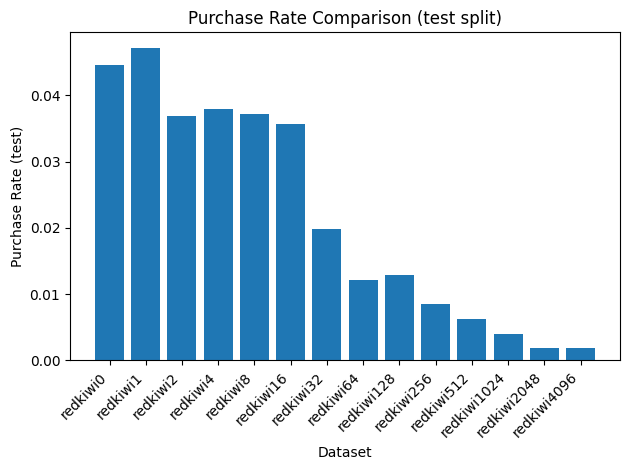

In [3]:
import json
import os
from glob import glob
import matplotlib.pyplot as plt


def plot_purchase_rates(
    data_root="../../data",
    split="train",
    dataset_order=None
):
    data = {}

    for dataset_dir in glob(os.path.join(data_root, "*")):
        info_path = os.path.join(dataset_dir, "dataset_info.json")
        if not os.path.exists(info_path):
            continue

        with open(info_path, "r", encoding="utf-8") as f:
            info = json.load(f)

        data[info["dataset_name"]] = info["purchase_rates"][split]

    # 🔹 custom_order에 있는 것만 사용
    if dataset_order is not None:
        ordered_names = [d for d in dataset_order if d in data]
    else:
        ordered_names = sorted(data.keys())

    purchase_rates = [data[name] for name in ordered_names]

    plt.figure()
    plt.bar(ordered_names, purchase_rates)
    plt.xlabel("Dataset")
    plt.ylabel(f"Purchase Rate ({split})")
    plt.title(f"Purchase Rate Comparison ({split} split)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


custom_order = [
    # "alipay",
    # "amazon",
    # "taobao",
    # "tmall",
    "redkiwi0",
    "redkiwi1",
    "redkiwi2",
    "redkiwi4",
    "redkiwi8",
    "redkiwi16",
    "redkiwi32",
    "redkiwi64",
    "redkiwi128",
    "redkiwi256",
    "redkiwi512",
    "redkiwi1024",
    "redkiwi2048",
    "redkiwi4096"
]
# custom_order에 있는 것 만 시각화 함.
plot_purchase_rates(split="test", dataset_order=custom_order)


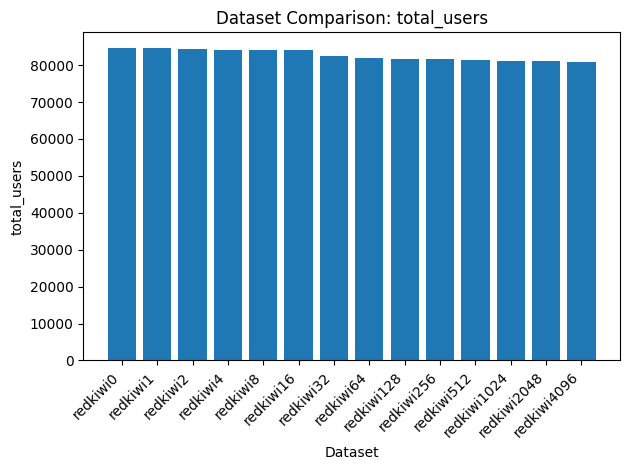

In [4]:
import json
import os
from glob import glob
import matplotlib.pyplot as plt


def get_nested_value(d, key_path):
    """
    key_path 예:
    - 'total_users'
    - 'splits.train'
    - 'purchase_rates.test'
    """
    keys = key_path.split(".")
    for k in keys:
        d = d[k]
    return d


def plot_dataset_metric(
    data_root="../../data",
    metric="total_users",   # 비교할 항목
    dataset_order=None      # 시각화할 dataset 순서 (있으면 그것만)
):
    data = {}

    for dataset_dir in glob(os.path.join(data_root, "*")):
        info_path = os.path.join(dataset_dir, "dataset_info.json")
        if not os.path.exists(info_path):
            continue

        with open(info_path, "r", encoding="utf-8") as f:
            info = json.load(f)

        dataset_name = info["dataset_name"]
        value = get_nested_value(info, metric)
        data[dataset_name] = value

    # X축 순서 결정 (custom_order에 있는 것만)
    if dataset_order is not None:
        ordered_names = [d for d in dataset_order if d in data]
    else:
        ordered_names = sorted(data.keys())

    values = [data[name] for name in ordered_names]

    plt.figure()
    plt.bar(ordered_names, values)
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.title(f"Dataset Comparison: {metric}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


plot_dataset_metric(metric="total_users", dataset_order=custom_order)

# tuner_config.csv 시각화

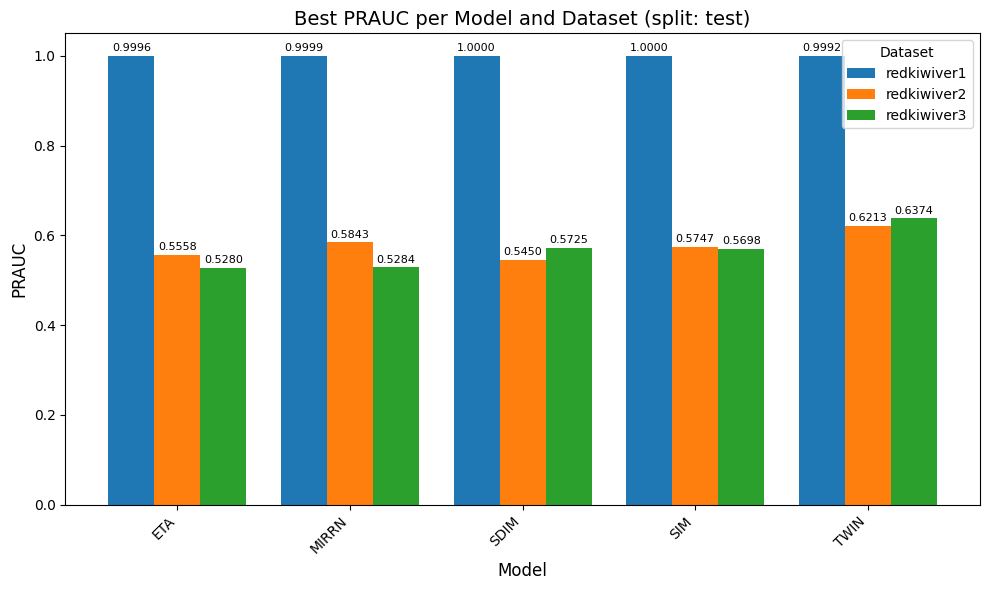

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display

# results에서 설정 바람
'''
1. ./results/max_len_500/tuner_config_all.csv : 모든 모델, 모든 데이터 셋에 대해서 전처리 없이 실험한 것 
2. ./results/max_len_5000/tuner_config.csv : 
3. ./results/max_len_50/tuner_config.csv : 
4. ./results/exclude_len_redkiwi/tuner_config.csv
'''

# 1. CSV 불러오기 (파일 경로는 상황에 맞게 수정)
df = pd.read_csv("./results/max_len_5000/tuner_config.csv")

# 2. 컬럼 자동 탐색 (현재 파일 포맷 기준)
exp_col      = [c for c in df.columns if c.strip().startswith('[exp_id]')][0]
dataset_col  = [c for c in df.columns if c.strip().startswith('[dataset_id]')][0]
val_col      = [c for c in df.columns if c.strip().startswith('[val]')][0]
test_col     = [c for c in df.columns if c.strip().startswith('[test]')][0]

# 3. exp_id 에서 모델명 / 데이터셋명 파싱
def parse_model_dataset(s: str):
    # 예: "[exp_id] MIRRN_redkiwi_001_debcce1e"
    s = s.replace("[exp_id]", "").strip()
    parts = s.split("_")
    model = parts[0] if len(parts) > 0 else None
    dataset = parts[1] if len(parts) > 1 else None
    return pd.Series({"model": model, "dataset": dataset})

df[["model", "dataset"]] = df[exp_col].apply(parse_model_dataset)

# 4. 사용할 스플릿(val / test) 선택
EVAL_SPLIT = "test"    # "val" 또는 "test" 로 바꿔서 사용
metric_str_col = val_col if EVAL_SPLIT == "val" else test_col

# 5. 메트릭 문자열 파싱
# 예: "[val] PRAUC: 0.997304 - AUC: 0.999919 - logloss: 0.005178"
pattern = re.compile(
    r"PRAUC:\s*([\d\.]+)\s*-\s*AUC:\s*([\d\.]+)\s*-\s*logloss:\s*([\d\.]+)"
)

def parse_metrics(s: str):
    m = pattern.search(str(s))
    if m:
        return pd.Series({
            "PRAUC": float(m.group(1)),
            "AUC": float(m.group(2)),
            "logloss": float(m.group(3)),
        })
    else:
        return pd.Series({
            "PRAUC": float("nan"),
            "AUC": float("nan"),
            "logloss": float("nan"),
        })

df[["PRAUC", "AUC", "logloss"]] = df[metric_str_col].apply(parse_metrics)

# 6. Y축에 쓸 메트릭 선택 (여기를 바꿔서 사용)
#    가능 값: "PRAUC", "AUC", "logloss"
METRIC = "PRAUC"      # "AUC" 또는 "logloss" 로 변경 가능

# 해당 메트릭 값이 없는 행 제거
df_metric = df.dropna(subset=[METRIC]).copy()

# 7. 모델×데이터셋별로 최고의 설정 선택
grouped = df_metric.groupby(["model", "dataset"])[METRIC]

if METRIC == "logloss":
    # logloss는 낮을수록 좋음 → 최소값 선택
    best_idx = grouped.idxmin()
else:
    # AUC / PRAUC는 높을수록 좋음 → 최대값 선택
    best_idx = grouped.idxmax()

best_df = df_metric.loc[best_idx].reset_index(drop=True)

# 8. 피벗: 행=model, 열=dataset, 값=선택한 METRIC
pivot = best_df.pivot(index="model", columns="dataset", values=METRIC)
pivot = pivot.sort_index()  # 모델 이름 기준 정렬 (원하지 않으면 생략)

# ------------------------------
# (1) 멀티 바 플롯 + 바 위에 값 표시
# ------------------------------
ax = pivot.plot(
    kind="bar",
    figsize=(10, 6),
    width=0.8  # 한 모델 그룹 전체 폭
)

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel(METRIC, fontsize=12)
ax.set_title(f"Best {METRIC} per Model and Dataset (split: {EVAL_SPLIT})", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset")

# === bar 위에 값 써주기 ===
# matplotlib >= 3.4 기준
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=8, fmt='%.4f') # 

plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------
# (2) Table 시각화
#     X축: 데이터셋(열), Y축: 모델(행)
#     - 각 데이터셋(열)에서
#       * 가장 큰 값: bold
#       * 그 다음 값: underline
#     - 값이 없는 경우: "-"
# ------------------------------

# 숫자 기준 계산용 (NaN 포함)
numeric_pivot = pivot.copy()

# 스타일 함수: 각 열(column) 기준으로 top-1 bold, top-2 underline
def highlight_top_two(col):
    # col: 한 컬럼(= 한 데이터셋)에 대한 시리즈
    styles = [''] * len(col)
    non_na = col.dropna()

    if len(non_na) >= 1:
        # 최대값 인덱스
        max_idx = non_na.idxmax()
        pos = col.index.get_loc(max_idx)
        styles[pos] += 'font-weight: bold;'

    if len(non_na) >= 2:
        # 두 번째로 큰 값 인덱스
        sorted_idx = non_na.sort_values(ascending=False).index
        second_idx = sorted_idx[1]
        pos2 = col.index.get_loc(second_idx)
        styles[pos2] += 'text-decoration: underline;'

    return styles

# 값이 없는 곳은 "-" 로 표시, 있는 값은 소수 4자리까지
styled = (
    numeric_pivot
    .style
    .apply(highlight_top_two, axis=0)  # 열 기준 스타일 적용
    .format(lambda v: "-" if pd.isna(v) else f"{v:.6f}")
)

display(styled)


dataset,redkiwiver1,redkiwiver2,redkiwiver3
model,,,
ETA,0.999234,0.614587,0.522794
MIRRN,0.999847,0.608259,0.519553
SDIM,0.999333,0.531361,0.450708
SIM,0.999507,0.598925,0.549177
TWIN,0.999636,0.612230,0.536889


# 데이터 셋 별 구매자 비율 확인